🔍 Die at (36, 26) on wafer '0fDCmN' is: Good


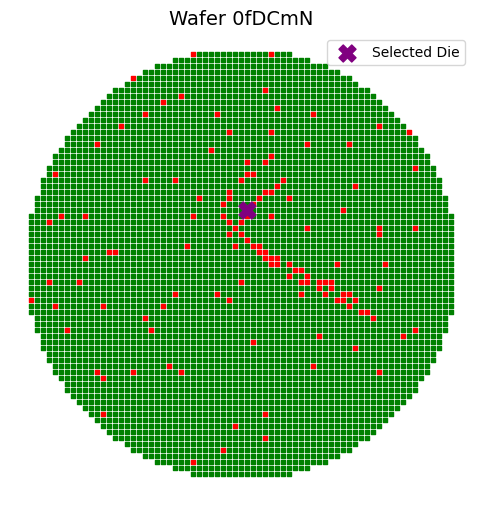

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile

zf = zipfile.ZipFile('./../data.zip') 

TEST_CSV = 'wafers_test.csv'

# 2. Load test data
df_test = pd.read_csv(zf.open('wafers_test.csv'))

def plot_die_status_test(df, wafer_name, die_x, die_y):
    """
    Given a wafer name and coordinates (die_x, die_y),
    - Prints whether that die is Good or Bad
    - Plots the entire wafer (circular), coloring:
        green = good, red = bad
    - Highlights the selected die in purple
    """
    # Filter to the wafer
    wafer_df = df[df['WaferName'] == wafer_name]
    if wafer_df.empty:
        print(f"❌ Wafer '{wafer_name}' not found.")
        return

    # Locate the die
    die = wafer_df[(wafer_df['DieX'] == die_x) & (wafer_df['DieY'] == die_y)]
    if die.empty:
        print(f"❌ Die at ({die_x}, {die_y}) not found on wafer '{wafer_name}'.")
        return
    r = die.iloc[0]

    # Determine status
    status = "Good" if r.IsGoodDie else "Bad"
    print(f"🔍 Die at ({die_x}, {die_y}) on wafer '{wafer_name}' is: {status}")

    # Build colors array
    colors = np.where(wafer_df.IsGoodDie, 'green', 'red')

    # Plot
    plt.figure(figsize=(6,6))
    plt.scatter(wafer_df.DieX, wafer_df.DieY,
                c=colors, s=10, marker='s', label='_nolegend_')

    # Highlight selected die
    plt.scatter([die_x], [die_y],
                c='purple', s=150, marker='X', label='Selected Die')

    plt.title(f"Wafer {wafer_name}", fontsize=14)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal')   # keep circle shape
    plt.axis('off')
    plt.legend(loc='upper right')
    plt.show()


# ===== Example Usage =====
plot_die_status_test(df_test, wafer_name='0fDCmN', die_x=36, die_y=26)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Configuration – update these paths:
TEST_CSV  = './../data/wafers_test.csv'
PRED_CSV  = './../20250504_Oran Bourak_oranbourak@gmail.com_df_wafers_test_with_preds.csv'
OUTPUT_DIR = 'wafer_comparison_plots'
FIGSIZE    = (12, 6)   # width, height in inches

# 2. Prepare output folder
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3. Load data
df_test = pd.read_csv(
    TEST_CSV,
    dtype={
        'WaferName': 'category',
        'DieX'     : 'int16',
        'DieY'     : 'int16',
        'IsGoodDie': 'bool'
    }
)

df_pred = pd.read_csv(
    PRED_CSV,
    usecols=['WaferName','DieX','DieY','IsScratchDie'],
    dtype={
        'WaferName'       : 'category',
        'DieX'            : 'int16',
        'DieY'            : 'int16',
        'IsScratchDie': 'int8'
    }
)

# 4. Merge actual + predicted
df = pd.merge(
    df_test,
    df_pred,
    on=['WaferName','DieX','DieY'],
    how='left'
)
# any missing predictions → 0
df['IsScratchDie'] = df['IsScratchDie'].fillna(0).astype(int)

# 5. Plotting function
def plot_comparison(wafer_df, wafer_name):
    fig, (ax_act, ax_pred) = plt.subplots(
        1, 2,
        figsize=FIGSIZE
    )

    # --- Actual plot ---
    good = wafer_df[ wafer_df['IsGoodDie'] ]
    bad  = wafer_df[~wafer_df['IsGoodDie'] ]
    ax_act.scatter(
        good['DieX'], good['DieY'],
        c='green', s=10, marker='s', label='Good'
    )
    ax_act.scatter(
        bad['DieX'], bad['DieY'],
        c='red',   s=10, marker='s', label='Bad'
    )
    ax_act.set_title(f'{wafer_name} — Actual', fontsize=14)
    ax_act.axis('off')
    ax_act.set_aspect('equal')
    ax_act.legend(loc='upper right')

    # --- Predicted plot ---
    ax_pred.scatter(
        good['DieX'], good['DieY'],
        c='green', s=10, marker='s', label='Good'
    )
    ax_pred.scatter(
        bad['DieX'], bad['DieY'],
        c='red',   s=10, marker='s', label='Bad'
    )
    pred = wafer_df[ wafer_df['IsScratchDie'] == 1 ]
    ax_pred.scatter(
        pred['DieX'], pred['DieY'],
        c='purple', s=50, marker='X', label='Predicted Scratch'
    )
    ax_pred.set_title(f'{wafer_name} — Predicted', fontsize=14)
    ax_pred.axis('off')
    ax_pred.set_aspect('equal')
    ax_pred.legend(loc='upper right')

    plt.tight_layout()
    fig.savefig(
        os.path.join(OUTPUT_DIR, f'{wafer_name}.png'),
        bbox_inches='tight'
    )
    plt.close(fig)

# 6. Loop over wafers and save plots
for wafer_name, group in df.groupby('WaferName'):
    plot_comparison(group, wafer_name)

print(f"✅ Done! Plots saved to `{OUTPUT_DIR}/`")
